### Machine Learning: Exercise 1: Logistic Regression
This notebook is a Python implementation of Exercise 2 from the Machine Learning Course given by Andrew Ng on Coursera. It follows the live script including the optional excercises.<br>
**Author:** Pascal Wenger<br>
**Created:** 07.Sept 2018

In [25]:
# import libraries
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive
import seaborn as sns
print('#'*79) # guidance python pep: maximum lenght 79 characters

###############################################################################


In [2]:
# load data (the ex2data1.txt must be in the same directoy as this notebook)
# the first two columns contain the exam scores 
# and the third column contains the label
df = pd.read_csv('ex2data1.txt', header=None)
df.head(3)

,0,1,2
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0


In [3]:
X_raw = df.loc[:,[0,1]].values
y_raw = df.loc[:,2].values
print("X_raw: ", X_raw.shape)
print("y_raw: ", y_raw.shape)

X_raw:  (100, 2)
y_raw:  (100,)


#### Visualising Data

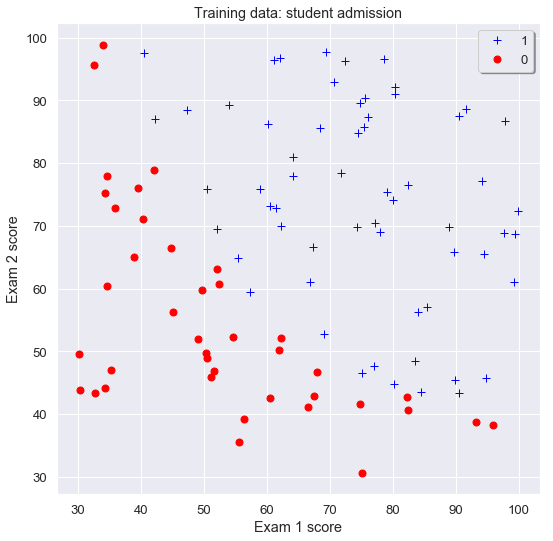

In [4]:
def plot_Data(X,y):
    """
    Plots the data points X and y into a new figure 
    plotdata(x,y) plots the data points with + for the positive examples
    and o for the negative examples. X is assumed to be a Mx2 matrix.
    """
    sns.set(font_scale=1.2)
    fig, ax = plt.subplots(figsize=(22/2.54, 22/2.54))
    
    ax.plot(X[:,0][y==1], X[:,1][y==1], '+', color='blue',
            markersize=8, label='1',  mew=1)
    
    ax.plot(X[:,0][y==0], X[:,1][y==0], 'o', color='red',
            markersize=7, markerfacecolor='red', label='0', mew=1)
    
    return fig, ax

fig, ax = plot_Data(X_raw, y_raw)
ax.set_title("Training data: student admission")
ax.set_xlabel("Exam 1 score")
ax.set_ylabel("Exam 2 score")
plt.legend(loc='upper right',frameon=True, shadow=True)
plt.show()

#### Sigmoid function

In [5]:
def sigmoid(z):
    """compute the sigmoid function"""
    
    g = 1 / (1 + np.exp(-z))
    
    return g

In [6]:
# input values to the sigmoid function to check implementation:
print("sigmoid(-5): {:2.3f}".format(sigmoid(-5)))
print("sigmoid( 0): {:2.3f}".format(sigmoid(0)))
print("sigmoid( 5): {:2.3f}".format(sigmoid(5)))

sigmoid(-5): 0.007
sigmoid( 0): 0.500
sigmoid( 5): 0.993


#### Cost and gradient function

In [7]:
def costFunc_LogRegression(theta, X, y):
    """
    compute the cost function
    Input:     parameters theta
               matrix X
               result vector y
    Output:    cost value J
    Functions: sigmoid() 
    """
    
    # length of training data
    m = y.shape[0]
    
    # length of theta
    n = len(theta)
    
    # adapt shape for scipy.optimize.minimize function:
    theta = theta.reshape((n,1))
    
    # sigmoid(X @ theta), @ is short for np.matmul:
    sig_h_theta_x = sigmoid(X @ theta)
    
    # calculate cost value:
    k = (-y*np.log(sig_h_theta_x) - (1-y)*np.log(1-sig_h_theta_x))
    J = 1/m * sum(k)

    return J


def gradFunc_LogRegression(theta, X, y):
    """
    compute the grad function
    Input:  parameters theta
            matrix X
            result vector y
    Output: grad vector
    """
    
    # length of training data:
    m = y.shape[0]
    
    # length of theta:
    n = len(theta)
    
    # adapt shape for scipy.optimize.minimize function:
    theta = theta.reshape((n,1))
    
    #initial setting:
    grad = np.zeros(theta.shape)
    
    # sigmoid(X * theta), @ is short for np.matmul:
    sig_h_theta_x = sigmoid(X @ theta)
    
    # calculated gradient vector:
    for j in range(len(theta)):
        grad[j] = 1/m * sum((sig_h_theta_x - y) * X[:,j].reshape(m,1)) 
     
    return grad.reshape(n)

#### Set parameters and show initial cost and gradient:

In [8]:
# Setup vector appropriately:
y = y_raw.reshape(len(y_raw),1)
#Add intercept term to X:
X = np.column_stack((np.ones((len(y),1)), X_raw))

# Initialize the fitting parameters:
theta_0 = np.zeros(3).reshape(3,1)

#Setup vector appropriately:
y = y.reshape(len(y),1)

# Compute and display the initial cost and gradient:
J = costFunc_LogRegression(theta_0, X, y)
grad = gradFunc_LogRegression(theta_0, X, y)

print("Cost at initial theta(zero): {:.6f}".format(J[0]))
print("Gradient at initial theta (zeros): " +
      "{:.4f}, {:.4f}, {:.4f}.".format(grad[0], grad[1], grad[2]))

Cost at initial theta(zero): 0.693147
Gradient at initial theta (zeros): -0.1000, -12.0092, -11.2628.


#### Learning parameters using *scipy.optimize.minimize*

In [9]:
theta = theta_0.reshape(len(theta_0))
theta = theta + 0.01 # to eliminate zero division warning

from scipy.optimize import minimize
res = minimize(costFunc_LogRegression, theta, args=(X,y), method='BFGS', 
               jac=gradFunc_LogRegression)
theta = res.x
cost = res.fun

print('Cost at theta found by fminunc: {:.6f}'.format(cost))
print("Theta at theta found by fminunc: " +
      "{:.4f}, {:.4f}, {:.4f}.".format(theta[0], theta[1], theta[2]))

Cost at theta found by fminunc: 0.203498
Theta at theta found by fminunc: -25.1611, 0.2062, 0.2015.


#### Plot data with decision boundary

In [22]:
def map_Feature(X1, X2, degree=6):
    """
    Feature mapping function to polynomial features
    mapFeature(X1, X2) maps the two input features
    to quadratic features used in the regularization exercise.

    Returns a new feature array with more features, comprising of 
    X1, X2, X1.^2, X1*X2, X2.^2, X1^3, X1^2*X2, ..., X1^1*X2^5, X2^6

    Inputs X1, X2 must be the same size
    """
    # length of training data
    m = X1.shape[0]

    # first column is filled with ones X0=1
    out = np.ones((m,1))
    
    for i in range(1, degree+1):
        
        for j in range(i+1):
            
            z = (X1**(i-j) * X2**j).reshape(m,1)
            
            out = np.append(out, z, axis=1)
            
    return out


def plotDecisionBoundary(theta, X, y):
    """
    Plots the data points X and y into a new figure with
    the decision boundary defined by theta
    plotDecisionBoundary(theta, X, y) plots the data points with + for the 
    positive examples and o for the negative examples. X is assumed to be 
    a either 
    1) Mx3 matrix, where the first column is an all-ones column for the 
       intercept.
    2) MxN, N>3 matrix, where the first column is all-ones
    """
    # Plot Data
    fig, ax = plot_Data(X[:,1:3], y[:,0])
    
    if X.shape[1] <= 3:
        # Only need 2 points to define a line, so choose two endpoints
        plot_x = np.array([min(X[:,2]),  max(X[:,2])]);
        
        # Calculate the decision boundary line
        plot_y = -1/theta[2] * (theta[0] + theta[1]*plot_x)
    
        # Plot, and adjust axes for better viewing
        ax.plot(plot_x, plot_y, linewidth=3, color='green', 
                label='decision boundary')
    
    else:
        # Here is the grid range
        u = np.linspace(-1, 1.5, 50)
        v = np.linspace(-1, 1.5, 50)
        z = np.zeros((len(u), len(v)))
        
        # Evaluate z = theta*x over the grid
        for h in range(len(u)):
            
            for k in range(len(v)):
                
                Xi = map_Feature(np.array([u[h]]), np.array([v[k]]))
                z[h,k] = Xi @theta
                
        z = z.T 
        ax.contour(u, v, z, 0, colors='green')
        
    return fig, ax

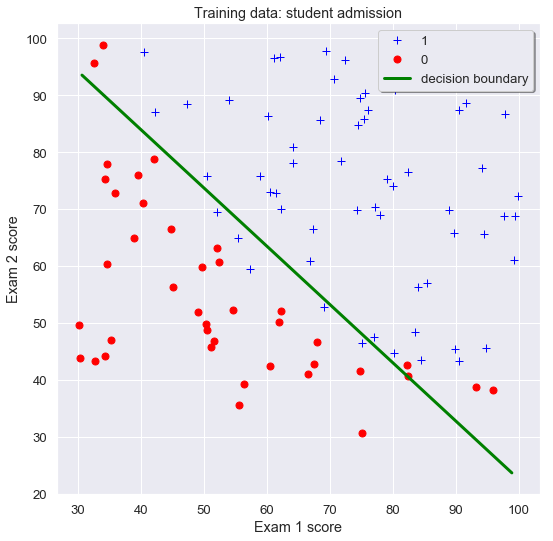

In [11]:
# plot data
fig, ax = plotDecisionBoundary(theta, X, y)
ax.set_title("Training data: student admission")
ax.set_xlabel("Exam 1 score")
ax.set_ylabel("Exam 2 score")
plt.legend(loc='upper right',frameon=True, shadow=True)
plt.show()

#### Evaluating logistic regression

In [12]:
# Predict probability for a student with score 45 on exam 1  
# and score 85 on exam 2 
prob = sigmoid(np.array([1, 45,85]).reshape((1,3)) @ theta)
print("For a student with scores 45 & 85, we predict an\nadmission " + 
      "probability of {:.6f}.".format(prob[0]))

For a student with scores 45 & 85, we predict an
admission probability of 0.776289.


In [13]:
def predict(theta, X):
    """
    Predict whether the label is 0 or 1 using learned logistic 
    regression parameters theta
    p = predict(theta, X)computes the predictions for X using a 
    threshold at 0.5 (i.e., if sigmoid(theta'*x) >= 0.5, predict 1)
    """
    m = X.shape[0] # Number of training examples
    
    # adapte shape for matmul function:
    theta = theta.reshape((len(theta),1))
     
    # container for prediction values set initialy all to zero
    p = np.zeros((m, 1))

    # sigmoid(X * theta):
    z = sigmoid(X @ theta)
    
    # set values in p to 1 where value >=0.5
    pos = np.where(z >= 0.5) 
    p[pos] = 1
    
    return p

In [14]:
# Compute accuracy on our training set
p = predict(theta, X)
print("Train Accuracy: {:.3f} %".format(np.mean((p==y).astype(int))*100))

Train Accuracy: 89.000 %


### Regularized logistic regression

#### visualizing data

In [15]:
# load data (the ex2data2.txt must be in the same directoy as this notebook)
# the first two columns contain the exam scores 
# and the third column contains the label
df = pd.read_csv('ex2data2.txt', header=None)
X_raw = df.loc[:,[0,1]].values
y_raw = df.loc[:,2].values

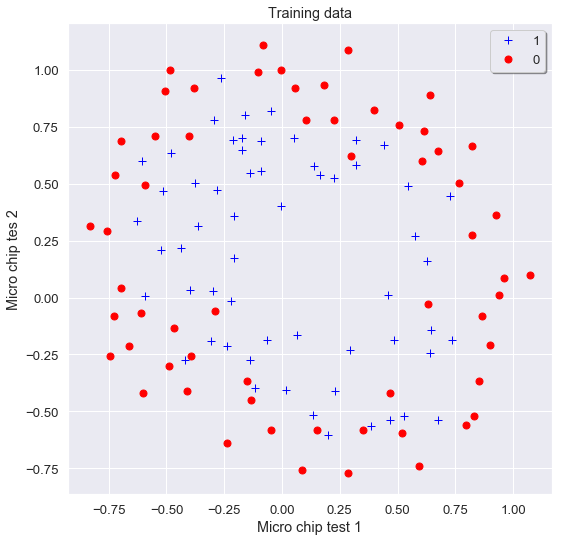

In [16]:
# visualize data
fig, ax = plot_Data(X_raw, y_raw)
ax.set_title("Training data")
ax.set_xlabel("Micro chip test 1")
ax.set_ylabel("Micro chip tes 2")
plt.legend(loc='upper right',frameon=True, shadow=True)
plt.show()

#### Feature maping

In [17]:
# Add Polynomial Features
# Note that mapFeature also adds a column of ones for us, 
# so the intercept term is handled
X = map_Feature(X_raw[:,0], X_raw[:,1])

# Setup vector appropriately
y = y_raw.reshape(len(y_raw),1)

print("Shape of X:", X.shape)

Shape of X: (118, 28)


#### Cost function and gradient (regularized)

In [18]:
def costFunc_LogRegression_Regularized(theta, X, y, lambda_reg=1):
    """
    compute the regularized cost function
    Input:     parameters theta
               matrix X
               result vector y
    Output:    cost value J
    Functions: sigmoid() 
    """
    
    # length of training data
    m = y.shape[0]
    
    # length of theta
    n = len(theta)
    
    # adapte shape for matmul function:
    theta = theta.reshape((n,1))
    
    # sigmoid(X * theta):
    sig_theta_x = sigmoid(X @ theta)
    
    # calculate cost value:
    K = 1/m * sum(-y*np.log(sig_theta_x) - (1-y)*np.log(1-sig_theta_x))
    
    R = lambda_reg/(2*m) * sum(theta[1:]**2)

    J = K + R
    
    return J


def gradFunc_LogRegression_Regularized(theta, X, y, lambda_reg=1):
    """
    compute the regularized grad function
    Input:  parameters theta
            matrix X
            result vector y
    Output: grad vector
    """
    # length of training data
    m = y.shape[0]
    
    # length of theta
    n = len(theta) 
    
    # adapte shape for matmul function:
    theta = theta.reshape((n,1))
    
    #initial setting:
    grad = np.zeros(theta.shape)
    
    # sigmoid(X * theta):
    sig_theta_x = sigmoid(X @ theta)

    # calculated gradient vector:
    j = 0
    grad[j] = 1/m *sum((sig_theta_x - y) * X[:,j].reshape(m,1))
    
    #for j>0:
    for j in range(1,len(theta)):

        K = 1/m * sum((sig_theta_x - y) * X[:,j].reshape(m,1)) 
        
        grad[j] = K + lambda_reg/m * theta[j]
    
    
    return grad.reshape(n)


#### Learning parameters using *scipy.optimize.minimize*

In [19]:
# Initialize fitting parameters
theta_0 = np.zeros(X.shape[1])
theta_0 = theta_0 + 0.01 # to eliminate zero division warning

# Set regularization parameter lambda to 1
lr = 1

# Compute and display initial cost and gradient for regularized 
# logistic regression
cost = costFunc_LogRegression_Regularized(theta_0, X, y, lambda_reg=lr)
grad = gradFunc_LogRegression_Regularized(theta_0, X, y, lambda_reg=lr)

print("Cost at initial theta (zeros): {:.6f}".format(cost[0]))
print("Shape of grad:", grad.shape) 

Cost at initial theta (zeros): 0.697700
Shape of grad: (28,)


In [20]:
# optimze:
res = minimize(costFunc_LogRegression_Regularized, theta_0, 
               args = (X, y, lr), method = 'BFGS', 
               jac = gradFunc_LogRegression_Regularized)

theta = res.x
cost = res.fun
iterations = res.nit

print('Cost at theta found by fminunc: {:.6f}'.format(cost))
print("Number of iterations {}.".format(iterations))
#print("Theta at theta found by fminunc:", theta)   

Cost at theta found by fminunc: 0.529003
Number of iterations 46.


#### Plot data with decision boundary

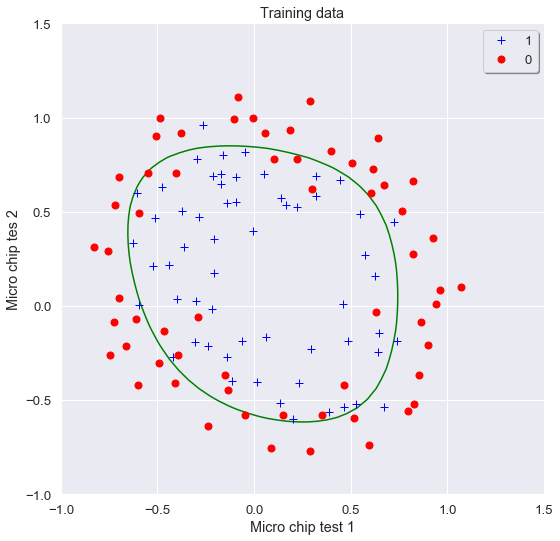

In [23]:
# Plot Boundary
fig, ax = plotDecisionBoundary(theta, X, y)
ax.set_title("Training data")
ax.set_xlabel("Micro chip test 1")
ax.set_ylabel("Micro chip tes 2")
plt.legend(loc='upper right',frameon=True, shadow=True)
plt.show()

In [24]:
# Compute accuracy on our training set
p = predict(theta, X);

print("Train Accuracy: {:.2f} %".format(np.mean((p==y).astype(int))*100))

Train Accuracy: 83.05 %


In [50]:
# define function for intreractive plot
def reg_plot(lr = 1):
    theta_0 = np.zeros(X.shape[1])
    theta_0 = theta_0 + 0.01 # to eliminate zero division warning
    # optimze:
    res = minimize(costFunc_LogRegression_Regularized, theta_0, 
                   args = (X, y, lr), method = 'BFGS', 
                   jac = gradFunc_LogRegression_Regularized)
    theta = res.x
    p = predict(theta, X);
    
    # Plot Boundary
    fig, ax = plotDecisionBoundary(theta, X, y)
    s0 = "Training Accuracy: {:2.2f} %".format(np.mean((p==y).astype(int))*100)
    s1 = "   "
    s2 = "lambda = {:4.0f}".format(lr)
    ax.set_title(s0 + s1 + s2, fontsize=18)
    ax.set_xlabel("Micro chip test 1")
    ax.set_ylabel("Micro chip tes 2")
    plt.legend(loc='upper right',frameon=True, shadow=True)
    plt.show()

#### Interactive plot (takes a few seconds to compute the new bondary)

In [51]:
# display interactive plot:
w = interactive(reg_plot, lr=(0, 150))
display(w)

interactive(children=(IntSlider(value=1, description='lr', max=150), Output()), _dom_classes=('widget-interact…

In [ ]:
############################# END of File #####################################